In [16]:
# General 
import sys
import math
import time
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
#GPyTorch
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import tqdm
#Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Ground Truth Windfield

## Load the wind field generator

In [17]:
class WindCalculator:
    def __init__(self,windfield_params):
        self.windfield_params = windfield_params
        self.windfield_params = windfield_params
        self.use_custom_windfield = self.windfield_params['use_custom_windfield']
        self.wind_direction = self.windfield_params['wind_direction']
        self.wind_velocity = self.windfield_params['wind_velocity']
        wind_norm = np.sqrt(self.wind_direction[0] ** 2 + self.wind_direction[1] ** 2 + self.wind_direction[2] ** 2)
        self.wind_direction = self.wind_direction / wind_norm
        if self.use_custom_windfield:
            windfield_path= self.windfield_params['windfield_path']
            try:
                f = open(windfield_path)
            except:
                print("File '" + windfield_path + "' does not exist!")
                exit(1)

            name = ""
            data = dict()
            for i in range(26):
                val = f.readline()
                if i % 2 == 0:
                    val = str(val)
                    val = val.replace(" ", "")
                    val = val.replace("\n", "")
                    val = val.replace(":", "")
                    name = val
                else:
                    line = np.fromstring(str(val), sep=" ")
                    if (len(line) == 1):
                        line = line[0]
                    data[name] = line

            self.min_x_ = data["min_x"]
            self.min_y_ = data["min_y"]
            self.n_x_ = int(data["n_x"])
            self.n_y_ = int(data["n_y"])
            self.res_x_ = data["res_x"]
            self.res_y_ = data["res_y"]
            self.vertical_spacing_factors_ = data["vertical_spacing_factors"]
            self.bottom_z_ = data["bottom_z"]
            self.top_z_ = data["top_z"]
            self.u_vec_ = data["u"]
            self.v_vec_ = data["v"]
            self.w_vec_ = data["w"]

            self.n_z = len(self.vertical_spacing_factors_)

    def linear_interpolation(self, position, values, points):
        value = values[0] + (values[1] - values[0]) / (points[1] - points[0]) * (position - points[0])
        return value

    def bilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[0], values[0:], points[0:]),
                                        self.linear_interpolation(position[0], values[2:], points[2:])])
        value = self.linear_interpolation(position[1], intermediate_values, points[4:])
        return value

    def trilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[2], values[0:], points[0:]),
                                        self.linear_interpolation(position[2], values[2:], points[2:]),
                                        self.linear_interpolation(position[2], values[4:], points[4:]),
                                        self.linear_interpolation(position[2], values[6:], points[6:])])
        value = self.bilinear_interpolation(position[0:],intermediate_values, points[8:])
        return value

    def calculate_windfield(self, link_position):

        if self.use_custom_windfield:
            # Calculate x,y index just smaller than aircraft position or equal to
            x_inf = math.floor((link_position[0] - self.min_x_) / self.res_x_)
            y_inf = math.floor((link_position[1] - self.min_y_) / self.res_y_)

            # In case aircraft is on one of the boundary surfaces at max_x or max_y,
            # decrease x_inf, y_inf by one to have x_sup, y_sup on max_x, max_y.
            if x_inf == self.n_x_ - 1:
                x_inf = self.n_x_ - 2
            if y_inf == self.n_y_ - 1:
                y_inf = self.n_y_ - 2

            # Calculate x,y index just larger than aircraft position
            x_sup = x_inf + 1
            y_sup = y_inf + 1

            # Save grid points enclosing the aircraft in an array
            n_vertices = 8
            idx_x = np.array([x_inf, x_inf, x_sup, x_sup, x_inf, x_inf, x_sup, x_sup])
            idx_y = np.array([y_inf, y_inf, y_inf, y_inf, y_sup, y_sup, y_sup, y_sup])

            # Find vertical factors in each of the four surrounding
            # grid columns, and their minimal/maximal value.
            n_columns = 4
            vertical_factors_columns = np.empty(n_columns)
            for i in range(n_columns):
                vertical_factors_columns[i] = (link_position[2] - self.bottom_z_[
                    idx_x[2 * i] + idx_y[2 * i] * self.n_x_]) \
                                              / (self.top_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_] -
                                                 self.bottom_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_])

            # Find minimal and maximal vertical factor
            vertical_factors_min = min(min(min(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])
            vertical_factors_max = max(max(max(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])

            # Check if aircraft is out of wind field or not, and act accordingly.
            if (x_inf >= 0 and y_inf >= 0 and vertical_factors_max >= 0 and
                    x_sup <= (self.n_x_ - 1) and y_sup <= (self.n_y_ - 1) and vertical_factors_min <= 1):
                # Find indices in z-direction for each of the vertices.If link is not
                # within the range of one of the columns, set to lowest or highest two.
                idx_z = [0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1]
                for i in range(n_columns):
                    if vertical_factors_columns[i] < 0:
                        # Link z - position below lowest grid point of that column
                        idx_z[2 * i + 1] = 1
                    elif vertical_factors_columns[i] >= 1:
                        # Link z-position above highest grid point of that column
                        idx_z[2 * i] = len(self.vertical_spacing_factors_) - 2
                    else:
                        # Link z-position between two grid points in that column.
                        for j in range(len(vertical_factors_columns) - 1):
                            if self.vertical_spacing_factors_[j] <= vertical_factors_columns[i] < \
                                    self.vertical_spacing_factors_[j + 1]:
                                idx_z[2 * i] = j
                                idx_z[2 * i + 1] = j + 1
                                break

                # Extract the wind velocities corresponding to each vertex
                wind_at_vertices = np.empty([8, 3])
                for i in range(n_vertices):
                    wind_at_vertices[i, 0] = self.u_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 1] = self.v_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 2] = self.w_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]

                # Extract the relevant coordinate of every point needed for trilinear interpolation
                n_points_interp_z = 8
                n_points_interp_x = 4
                n_points_interp_y = 2
                interpolation_points = np.empty(n_points_interp_x + n_points_interp_y + n_points_interp_z)
                for i in range(n_points_interp_x + n_points_interp_y + n_points_interp_z):
                    if i < n_points_interp_z:
                        interpolation_points[i] = (self.top_z_[idx_x[i] + idx_y[i] * self.n_x_] - self.bottom_z_[
                            idx_x[i] + idx_y[i] * self.n_x_]) \
                                                  * self.vertical_spacing_factors_[idx_z[i]] + self.bottom_z_[
                                                      idx_x[i] + idx_y[i] * self.n_x_]
                    elif n_points_interp_z <= i < n_points_interp_x + n_points_interp_z:
                        interpolation_points[i] = self.min_x_ + self.res_x_ * idx_x[2 * (i - n_points_interp_z)]
                    else:
                        interpolation_points[i] = self.min_y_ + self.res_y_ * idx_y[
                            4 * (i - n_points_interp_z - n_points_interp_x)]

                wind_v = self.trilinear_interpolation(link_position, wind_at_vertices, interpolation_points)
            else:
                print("Drone is outside of specified custom windfield, using default one")
                wind_v = self.wind_direction * self.wind_velocity
        else:
            wind_v = self.wind_direction * self.wind_velocity
        return wind_v

    def return_ground_truth(self):
        mean = []
        x = self.windfield_params['x'].flatten()
        y = self.windfield_params['y'].flatten()
        for i in range(x.size):
            link_position = [x[i], y[i], 2] #Random z parameter for now
            wind_v = self.calculate_windfield(link_position)
            mean.append(wind_v)
        mean = np.array(mean)
        return mean

## Create Grid

In [18]:
def create_grid(start, stop, res, array_type = None):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    if array_type is None:
        X = np.stack((x.flatten(), y.flatten()), axis=-1)
    else:
        X = torch.FloatTensor(np.stack((x.flatten(), y.flatten()), axis=-1))
    return X, x, y

In [216]:
X_grid, x_grid, y_grid = create_grid(-9.9,9.9,51)
X_grid_torch, x_grid_torch, y_grid_torch = create_grid(-9.9,9.9,51, "torch")

## Define wind field parameters and compute wind field 

In [466]:
wind_field_parameters = {'use_custom_windfield': True, \
                         'wind_direction': np.array([1.0, 1.0, 0.0]), \
                         'wind_velocity': 1.0, \
                         'x':x_grid, 'y':y_grid, \
                         'windfield_path':'/home/johanna/uav_mpcc/src/model_sim/include/custom_wind_fields/fan_x_dir_strength_5.txt'}
wind_calculator = WindCalculator(wind_field_parameters)
wind_gt = wind_calculator.return_ground_truth()[:,0:2]

## Visualize the windfield

In [329]:
def plot_wind_field(X=None, y=None, res=8, title=None, name=None):
    fig, ax = plt.subplots(1, 1)
    plt.axis('equal')
    plt.grid(linestyle=':')
    q = plt.quiver(X[::res, 0], X[::res, 1], y[::res,0], y[::res,1], scale=2.54, color='r',
                   units='width', scale_units="inches", width=0.003)
    plt.title(title, fontsize=16)
    plt.xlabel('x [m]', fontsize=14)
    plt.ylabel('y [m]', fontsize=14)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    plt.ioff()
    plt.autoscale()
    if not name==None:
        plt.savefig(name,  bbox_inches="tight")
    plt.show()

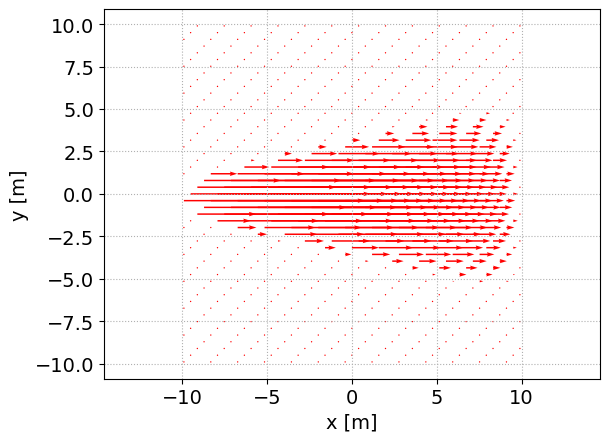

In [330]:
plot_wind_field(X_grid, wind_gt, 4, None, None)

# Active learning example

In [23]:
class Data:
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
    def set_data(self, X, y):
        self.X = X
        self.y = y
        self.read_data_torch()
    def read_data_torch(self):
        self.X_train =  torch.FloatTensor(self.X)
        self.y_train =  torch.FloatTensor(self.y)
        self.X_test =  torch.FloatTensor(self.X)
        self.y_test =  torch.FloatTensor(self.y)
    def read_data(self, inp):
        return

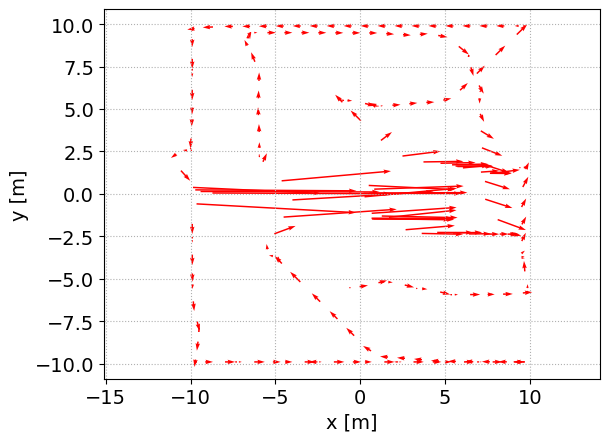

In [24]:
data1 = np.load('/home/johanna/MasterThesis/data/matern_path/wind_data_4.npz')
X1 = data1['X'][:,:]
y1 = data1['y'][:,:]
data1 = Data()
data1.set_data(X1,y1)
plot_wind_field(X1, y1, 4, None, None)

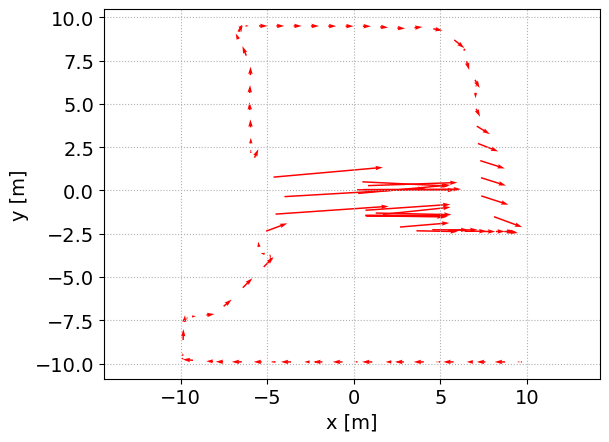

In [93]:
data2 = np.load('/home/johanna/MasterThesis/data/gauss_path/wind_data_2.npz')
X2 = data2['X'][:,:]
y2 = data2['y'][:,:]
data2 = Data()
data2.set_data(X2,y2)
plot_wind_field(X2, y2, 4, None, None)

In [455]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [456]:
class SparseGPyTorchRegression:
    def __init__(self, data, batch_size, epochs):
        # Change dataset to torch tensor
        self.data = data
        data.read_data("torch")
        self.likelihood = []
        self.model = []
        self.batch_size = batch_size
        self.n_epochs = epochs
        self.sigma_f = []
        self.length_scale = []
        self.sigma_n = []
    def fit(self):
        for i in range(self.data.y.shape[1]):
            train_dataset = TensorDataset(self.data.X_train, self.data.y_train[:,i])
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            inducing_points = self.data.X_train[::int(self.data.y.shape[0]/30), :]
            model = GPModel(inducing_points=inducing_points)
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model.train()
            likelihood.train()
            # Use the adam optimizer
            optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': likelihood.parameters()},
            ], lr=0.01)
            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=self.data.y_train[:,i].size(0))
            num_epochs = self.n_epochs
            epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
            for i in epochs_iter:
                # Within each iteration, we will go over each minibatch of data
                minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
                for x_batch, y_batch in minibatch_iter:
                    optimizer.zero_grad()
                    output = model(x_batch)
                    loss = -mll(output, y_batch)
                    minibatch_iter.set_postfix(loss=loss.item())
                    loss.backward()
                    optimizer.step()
            self.likelihood.append(likelihood)
            self.model.append(model)
        #self.save_kernel_params()
        
    def get_kernel_params(self):
        for i in range(self.data.y.shape[1]):
            self.sigma_f.append(self.model[i].covar_module.outputscale.item())
            self.length_scale.append([self.model[i].covar_module.base_kernel.lengthscale.detach().numpy().item(0),
                                      self.model[i].covar_module.base_kernel.lengthscale.detach().numpy().item(1)])
            self.sigma_n.append(self.likelihood[i].noise_covar.noise.item())
    def save_kernel_params(self):
        self.get_kernel_params()
        for i in range(self.data.y.shape[1]):
            name = "gpytorch_y" + str(i+1) + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
            self.data.save_kernel_params(name, self.length_scale[i], self.sigma_f[i], self.variance[i], self.sigma_n[i])
    def predict(self, X_test=None):
        if X_test == None:
            X_test = self.X_test
        self.mean = np.empty(X_test.shape)
        self.upper = np.empty(X_test.shape)
        self.lower = np.empty(X_test.shape)
        for i in range(self.data.y.shape[1]):
            self.model[i].eval()
            self.likelihood[i].eval()
            observed_pred = (self.model[i](X_test))
            self.mean[:,i] = observed_pred.mean.detach().numpy()
            lower, upper = observed_pred.confidence_region()
            self.upper[:,i] = upper.detach().numpy()
            self.lower[:,i] = lower.detach().numpy()
        #name = "gpytorch" + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
        #self.data.save_prediction(name, self.mean, self.upper, self.lower)
    def save_model(self):
        for i in range(self.data.y.shape[1]):
            print(self.model[i].state_dict())
            name = "gpytorch_y" + str(i+1) + "_model.pth"
            torch.save(self.model[i].state_dict(), name)

In [401]:
sparse_gp_torch = SparseGPyTorchRegression(data2, 20, 20)
sparse_gp_torch.fit()
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
MSE = mean_squared_error(wind_gt, y_pred)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

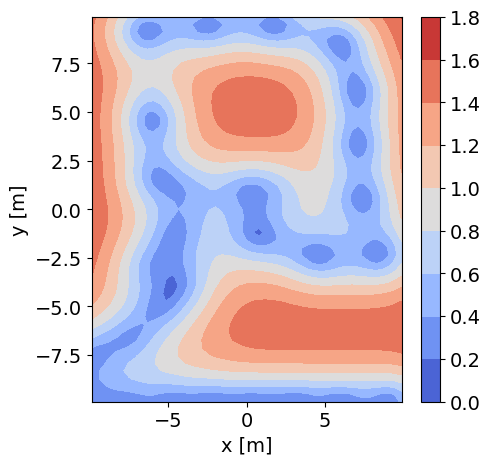

In [145]:
# Uncertainty map
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
name = '/home/johanna/thesis_plots/active_learning_1'
unc = (unc_y0 + unc_y1).reshape(51,51)
fig = plt.figure()
w = 5
h = 5
fig.set_size_inches(w,h)
contourf_ = plt.contourf(x_grid, y_grid, unc, cmap='coolwarm')
cbar = fig.colorbar(contourf_)
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.xlim([-9.9,9.9])
plt.ylim([-9.9,9.9])
if not name==None:
    plt.savefig(name,  bbox_inches="tight")
plt.show()

In [98]:
def compute_coordinate_distance(a, b):
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5

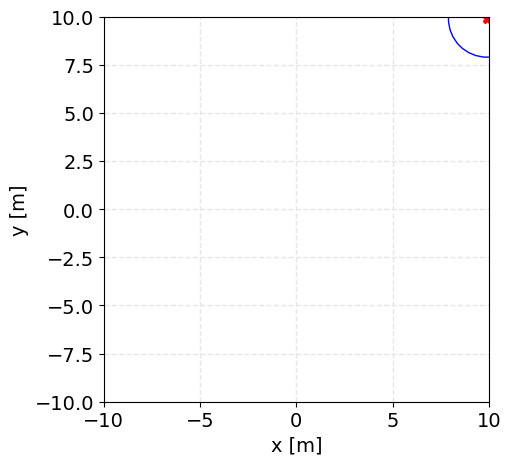

In [147]:
#Most uncertain point plus radius
name = '/home/johanna/thesis_plots/active_learning_2'
n_points = 10
radius = 2
fig, ax = plt.subplots()
w = 5
h = 5
fig.set_size_inches(w,h)
idx_0 = np.argsort(unc_y0 + unc_y1)[-1]
X_path = []
X_path.append(X_grid[idx_0])
ax.plot(X_path[0][0],X_path[0][1], 'rX')
circle=plt.Circle((X_path[0]),radius,color='b', fill=False)
ax.add_patch(circle)

i = 2
k = 0
while (len(X_path) < n_points):
    idx = np.argsort(unc_y0 + unc_y1)[-i]
    X_samp = X_grid[idx]
    dist_array = []
    for j in range(len(X_path)):
        dist = compute_coordinate_distance(X_samp, X_path[j])
        dist_array.append(dist)
        #ax.plot(X_samp[0],X_samp[1], color='0.8', marker='.')
    if not any(k < radius for k in dist_array):
        X_path.append(X_samp)
        k = k+1
        #ax.plot(X_path[k][0],X_path[k][1], 'rX')
        #circle=plt.Circle((X_path[k]),radius,color='b', fill=False)
        #ax.add_patch(circle)
    i = i+1
plt.xlim([-10,10])
plt.ylim([-10,10])
ax.set_aspect('equal')
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
if not name==None:
    plt.savefig(name,  bbox_inches="tight")
plt.show()

In [116]:
from python_tsp.exact import solve_tsp_dynamic_programming

def create_distance_matrix(X_path):
    distance_matrix = np.zeros((X_path.shape[0],X_path.shape[0]))
    for i in range(X_path.shape[0]):
        for j in range(X_path.shape[0]):
            distance = compute_coordinate_distance(X_path[i], X_path[j])
            distance_matrix[i,j] = distance
    return distance_matrix

def compute_permutation(X_path):
    distance_matrix = create_distance_matrix(X_path)
    permutation, distance = solve_tsp_dynamic_programming(distance_matrix)
    return permutation

def solve_tsp(X_path):
    permutation = compute_permutation(X_path)
    X_tsp = X_path[permutation,:]
    return X_tsp

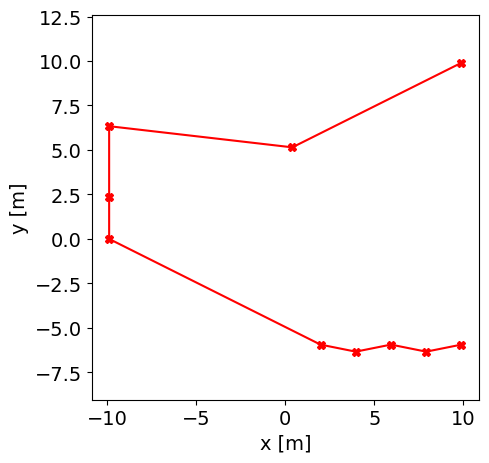

In [139]:
name = '/home/johanna/thesis_plots/active_learning_4'
X_path = np.reshape(X_path, (-1,2))
X_tsp = solve_tsp(X_path)
fig, ax = plt.subplots()
w = 5
h = 5
fig.set_size_inches(w,h)
plt.plot(X_tsp[:,0],X_tsp[:,1], '-rX')
plt.xlim([-10,10])
plt.ylim([-10,10])
ax.set_aspect('equal')
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.axis('equal')
if not name==None:
    plt.savefig(name,  bbox_inches="tight")
plt.show()

In [73]:
X_path[1]

array([ 1.98, -9.9 ])

In [45]:
X_path[0][0]

-9.9

In [31]:
X_path = []
X_path.append(X_grid[idx_0])

In [ ]:
fig = plt.figure()
contourf_ = plt.contourf(x_grid, y_grid, unc, cmap='coolwarm')
cbar = fig.colorbar(contourf_)
plt.show()

## Epochs and Batch Size

In [121]:
MSE_list = np.array([0])
time_list = np.array([0])
train = False #Set to true to do training
if train: 
    batch_size_list = [10,20,30,40,50]
    n_epochs_list = [10,20,30,40,50]
    for i in range(len(n_epochs_list)):
        for j in range(len(batch_size_list)):
            tic = time.time()
            sparse_gp_torch = SparseGPyTorchRegression(data1, batch_size_list[j], n_epochs_list[i])
            sparse_gp_torch.fit()
            sparse_gp_torch.predict(X_grid_torch)
            y_pred = sparse_gp_torch.mean
            MSE = mean_squared_error(wind_gt, y_pred)
            toc = time.time() -tic
            MSE_list = np.append(MSE_list, MSE)
            time_list = np.append(time_list, toc)
    np.savez('/home/johanna/MasterThesis/data/matern_path/results2.npz', time = time_list, MSE = MSE_list)

In [122]:
MSE_list = np.array([0])
time_list = np.array([0])
train = False #Set to true to do training
if train: 
    batch_size_list = [10,20,30,40,50]
    n_epochs_list = [10,20,30,40,50]
    for i in range(len(n_epochs_list)):
        for j in range(len(batch_size_list)):
            tic = time.time()
            sparse_gp_torch = SparseGPyTorchRegression(data2, batch_size_list[j], n_epochs_list[i])
            sparse_gp_torch.fit()
            sparse_gp_torch.predict(X_grid_torch)
            y_pred = sparse_gp_torch.mean
            MSE = mean_squared_error(wind_gt, y_pred)
            toc = time.time() -tic
            MSE_list = np.append(MSE_list, MSE)
            time_list = np.append(time_list, toc)
    np.savez('/home/johanna/MasterThesis/data/gauss_path/results2.npz', time = time_list, MSE = MSE_list)

In [124]:
#np.savez('/home/johanna/MasterThesis/data/gauss_path/results.npz', time = time_list, MSE = MSE_list)
matern_data = np.load('/home/johanna/MasterThesis/data/matern_path/results2.npz')
SE_data = np.load('/home/johanna/MasterThesis/data/gauss_path/results2.npz')

In [125]:
#Make a figure to compare the MSE data 
MSE_matern = matern_data["MSE"][1:].reshape((5,5))
time_matern = matern_data["time"][1:].reshape((5,5))
MSE_SE = SE_data["MSE"][1:].reshape((5,5))
time_SE = SE_data["time"][1:].reshape((5,5))
df_MSE_matern = pd.DataFrame(MSE_matern, columns = ['b10','b20','b30','b40','b50'])
df_time_matern = pd.DataFrame(time_matern, columns = ['b10','b20','b30','b40','b50'])
df_MSE_SE = pd.DataFrame(MSE_SE, columns = ['b10','b20','b30','b40','b50'])
df_time_SE = pd.DataFrame(time_SE, columns = ['b10','b20','b30','b40','b50'])
# Save to .csv file for plotting in latex
#df_MSE_SE.to_csv('/home/johanna/thesis_plots/MSE.csv')
#df_time_SE.to_csv('/home/johanna/thesis_plots/time.csv')

## Matern versus SE kernel

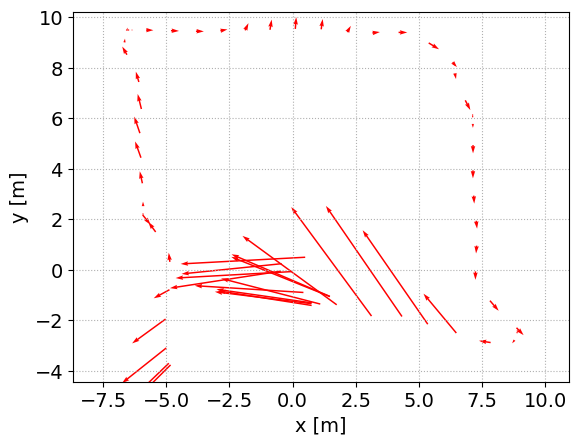

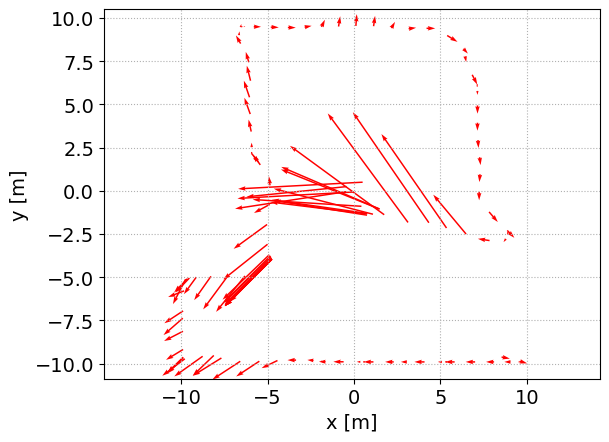

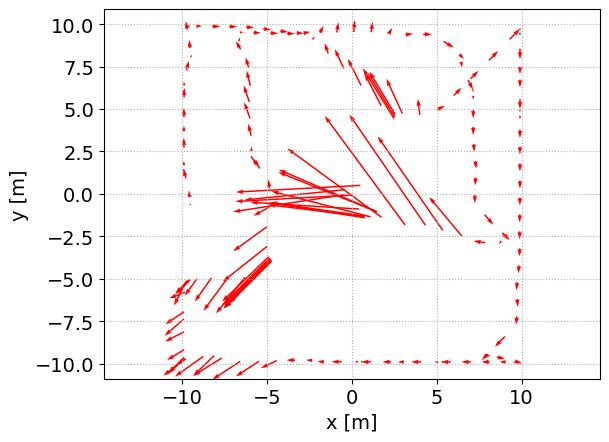

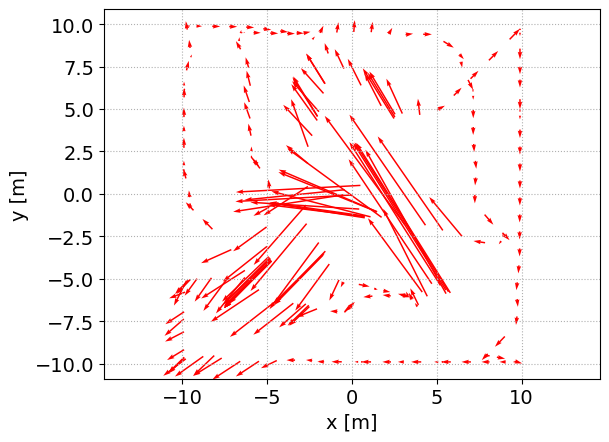

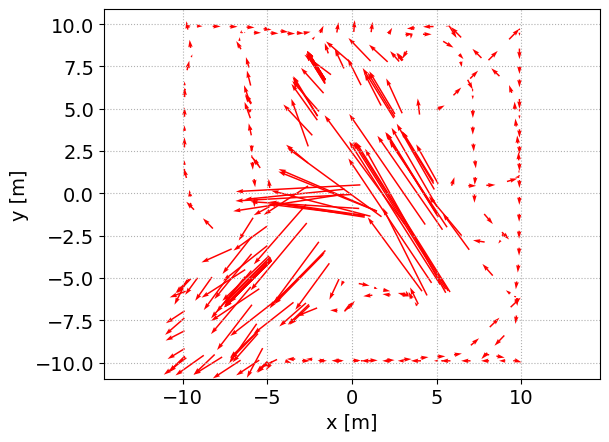

In [190]:
# Matern Kernel 2
data1 = np.load('/home/johanna/MasterThesis/data/matern_path_field2/wind_data_1.npz')
data2 = np.load('/home/johanna/MasterThesis/data/matern_path_field2/wind_data_2.npz')
data3 = np.load('/home/johanna/MasterThesis/data/matern_path_field2/wind_data_3.npz')
data4 = np.load('/home/johanna/MasterThesis/data/matern_path_field2/wind_data_4.npz')
data5 = np.load('/home/johanna/MasterThesis/data/matern_path_field2/wind_data_5.npz')
data_list_matern_raw = [data1, data2, data3, data4, data5]
data_list_matern_ = [data1, data2, data3, data4, data5]
j = 0
for i in data_list_matern_raw:
    X1 = i['X'][:,:]
    y1 = i['y'][:,:]
    i = Data()
    i.set_data(X1,y1)
    data_list_matern_[j] = i
    j = j+1
    name = "/home/johanna/thesis_plots/matern_path" + str(j) + ".png"
    plot_wind_field(X1, y1, 4, None, name)

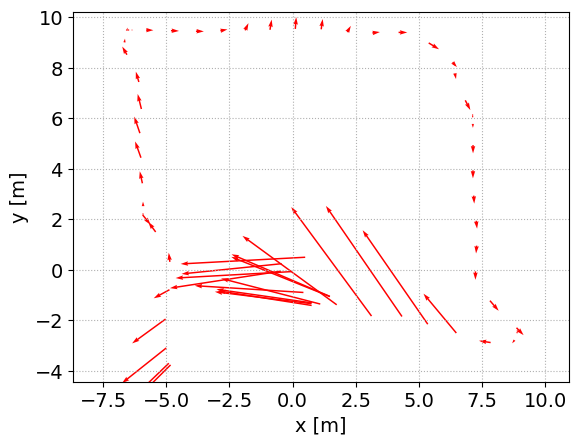

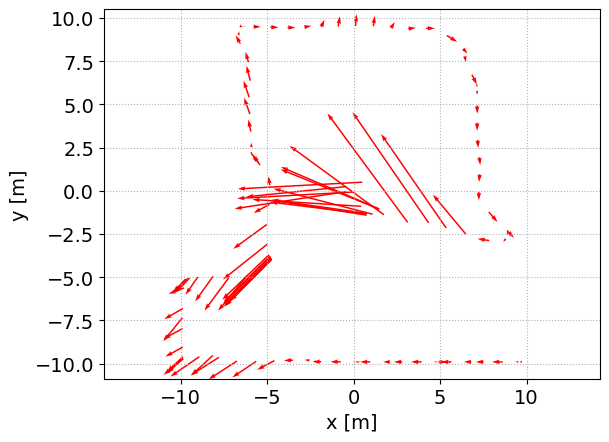

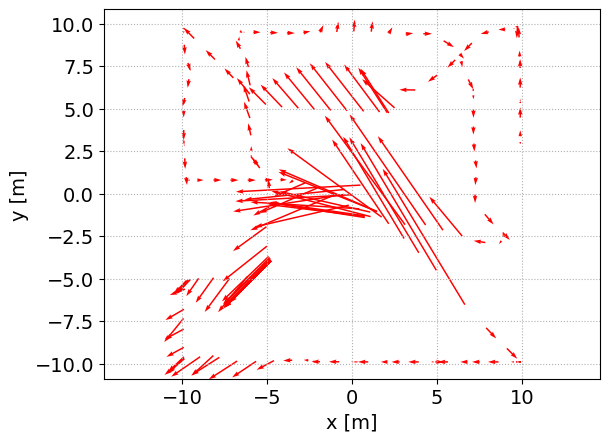

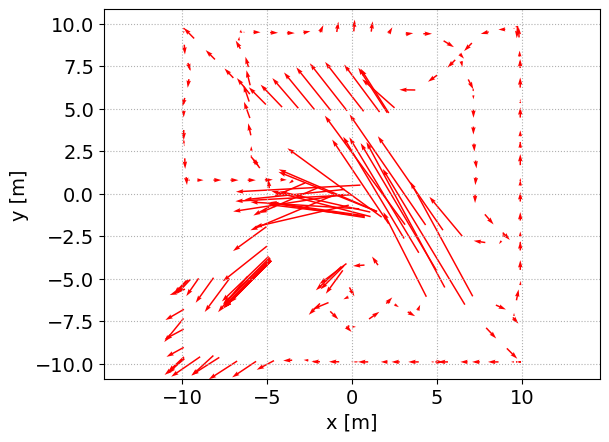

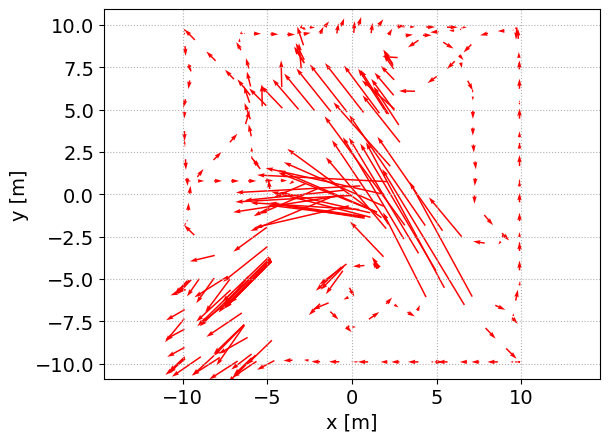

In [189]:
# SE Kernel 2
data1 = np.load('/home/johanna/MasterThesis/data/gauss_path_field2/wind_data_1.npz')
data2 = np.load('/home/johanna/MasterThesis/data/gauss_path_field2/wind_data_2.npz')
data3 = np.load('/home/johanna/MasterThesis/data/gauss_path_field2/wind_data_3.npz')
data4 = np.load('/home/johanna/MasterThesis/data/gauss_path_field2/wind_data_4.npz')
data5 = np.load('/home/johanna/MasterThesis/data/gauss_path_field2/wind_data_5.npz')
data_list_SE_raw = [data1, data2, data3, data4, data5]
data_list_SE_ = [data1, data2, data3, data4, data5]
j = 0
for i in data_list_SE_raw:
    X1 = i['X'][:,:]
    y1 = i['y'][:,:]
    i = Data()
    i.set_data(X1,y1)
    data_list_SE_[j] = i
    j = j+1
    name = "/home/johanna/thesis_plots/SE_path" + str(j) + ".png"
    plot_wind_field(X1, y1, 4, None, name)

In [203]:
MSE_list_SE = np.array([0])
mean_unc_list_SE = np.array([0])
max_unc_list_SE = np.array([0])
train = False #Set to true to do training
if train: 
    batch_size_list = [10,20,30,40,50]
    n_epochs = 20
    for j in range(len(data_list_SE_)):
        sparse_gp_torch = SparseGPyTorchRegression(data_list_SE_[j], batch_size_list[j], n_epochs)
        sparse_gp_torch.fit()
        sparse_gp_torch.predict(X_grid_torch)
        y_pred = sparse_gp_torch.mean
        MSE = mean_squared_error(wind_gt, y_pred)
        mean_unc = np.mean(sparse_gp_torch.upper - sparse_gp_torch.mean)
        max_unc = np.max(sparse_gp_torch.upper - sparse_gp_torch.mean)
        MSE_list_SE = np.append(MSE_list_SE, MSE)
        mean_unc_list_SE = np.append(mean_unc_list_SE, mean_unc)
        max_unc_list_SE = np.append(max_unc_list_SE, max_unc)

In [204]:
MSE_list_matern = np.array([0])
mean_unc_list_matern = np.array([0])
max_unc_list_matern = np.array([0])
train = False #Set to true to do training
if train: 
    batch_size_list = [10,20,30,40,50]
    n_epochs = 20
    for j in range(len(data_list_matern_)):
        sparse_gp_torch = SparseGPyTorchRegression(data_list_matern_[j], batch_size_list[j], n_epochs)
        sparse_gp_torch.fit()
        sparse_gp_torch.predict(X_grid_torch)
        y_pred = sparse_gp_torch.mean
        MSE = mean_squared_error(wind_gt, y_pred)
        mean_unc = np.mean(sparse_gp_torch.upper - sparse_gp_torch.mean)
        max_unc = np.max(sparse_gp_torch.upper - sparse_gp_torch.mean)
        MSE_list_matern = np.append(MSE_list_matern, MSE)
        mean_unc_list_matern = np.append(mean_unc_list_matern, mean_unc)
        max_unc_list_matern = np.append(max_unc_list_matern, max_unc)

In [205]:
# Save the data for plotting in in latex
MSE_compare = pd.DataFrame(np.vstack((MSE_list_matern, MSE_list_SE)).transpose(), columns = ['matern','SE'])
unc_compare = pd.DataFrame(np.vstack((mean_unc_list_matern, mean_unc_list_SE, max_unc_list_matern, max_unc_list_SE)).transpose(), columns = ['matern_mean','SE_mean','matern_max','SE_max'])
MSE_compare.to_csv('/home/johanna/thesis_plots/MSE_compare.csv')
unc_compare.to_csv('/home/johanna/thesis_plots/unc_compare.csv')

## Different path comparison

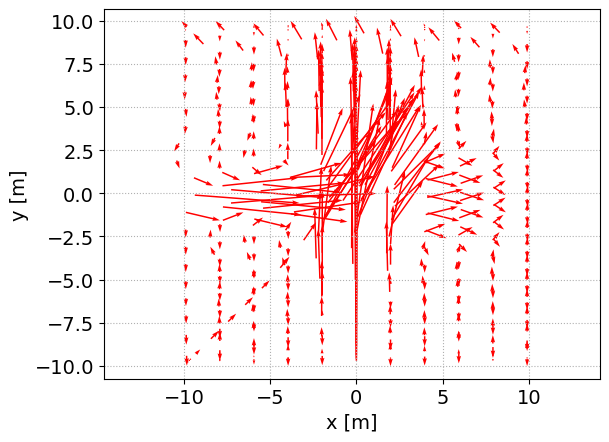

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

0.0338857153867146 0.5888495553772387 1.3392064720392227 46.4665002822876


In [282]:
# Structured path 
data1 = np.load('/home/johanna/MasterThesis/data/structured_path/wind_data_1.npz')
X1 = data1['X'][:,:]
y1 = data1['y'][:,:]
data1 = Data()
data1.set_data(X1,y1)
plot_wind_field(X1, y1, 4, None, "/home/johanna/thesis_plots/structured_data")
tic = time.time() -tic
sparse_gp_torch = SparseGPyTorchRegression(data1, 80, 20)
sparse_gp_torch.fit()
toc = time.time() -tic
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc, toc)

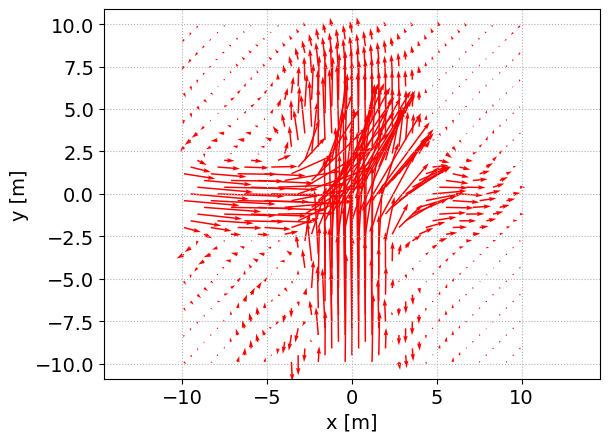

In [259]:
plot_wind_field(X_grid_torch, y_pred, 4, None, "/home/johanna/thesis_plots/structured_prediction")

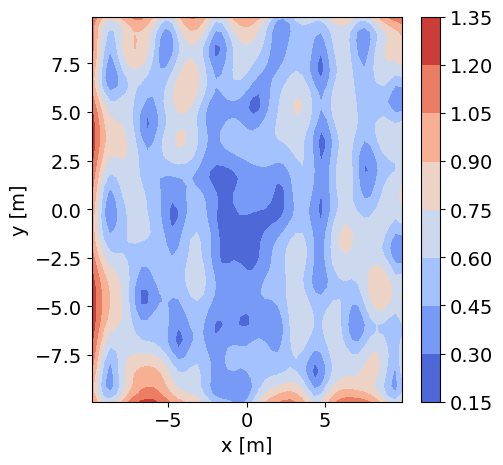

In [260]:
# Uncertainty map
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
name = '/home/johanna/thesis_plots/unc_structured_path'
unc = (unc_y0 + unc_y1).reshape(51,51)
fig = plt.figure()
w = 5
h = 5
fig.set_size_inches(w,h)
contourf_ = plt.contourf(x_grid, y_grid, unc, cmap='coolwarm')
cbar = fig.colorbar(contourf_)
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.xlim([-9.9,9.9])
plt.ylim([-9.9,9.9])
if not name==None:
    plt.savefig(name,  bbox_inches="tight")
plt.show()

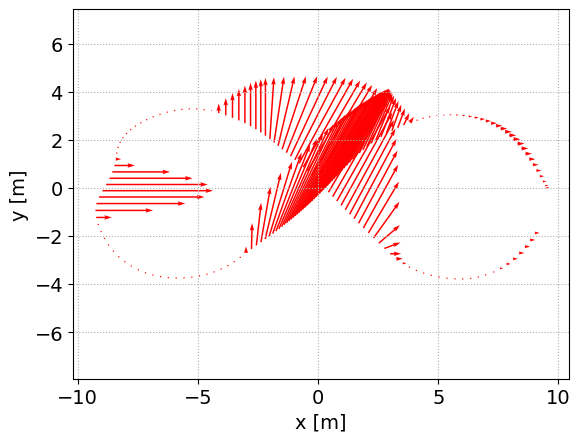

(767, 2)

In [286]:
# Lemniscate trajectory 
def read_data(filepath):
    training_data = pd.read_csv(filepath)
    training_data_array = training_data.to_numpy()
    X = np.stack((training_data_array[:, 0], training_data_array[:, 1]), axis=-1)
    y1 = training_data_array[:, 2]
    y2 = training_data_array[:, 3]
    y = np.vstack((y1,y2)).transpose()
    return X, y
X, y = read_data('/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_dir_2022-09-07-10-48-53.csv')
data1 = Data()
data1.set_data(X,y)
plot_wind_field(X, y, 4, None, "/home/johanna/thesis_plots/lemniscate_data")
tic = time.time()
sparse_gp_torch = SparseGPyTorchRegression(data1, 20, 20)
sparse_gp_torch.fit()
toc = time.time() -tic
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc,toc)

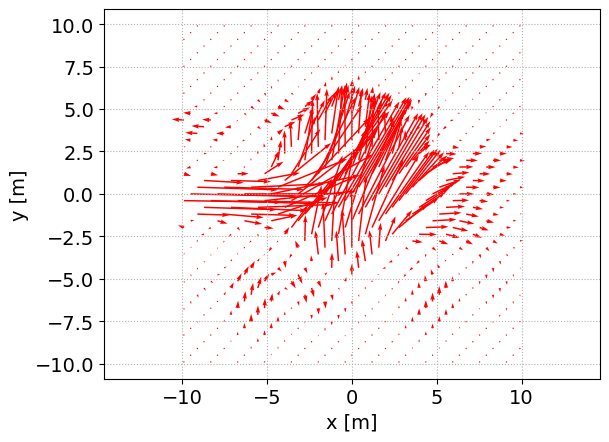

In [273]:
plot_wind_field(X_grid_torch, y_pred, 4, None, "/home/johanna/thesis_plots/lemniscate_prediction")

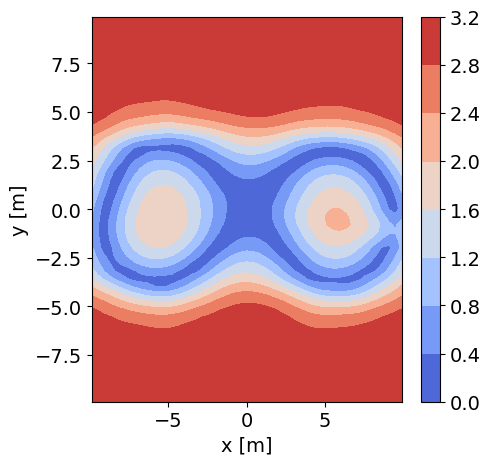

In [274]:
# Uncertainty map
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
name = '/home/johanna/thesis_plots/unc_lemniscate'
unc = (unc_y0 + unc_y1).reshape(51,51)
fig = plt.figure()
w = 5
h = 5
fig.set_size_inches(w,h)
contourf_ = plt.contourf(x_grid, y_grid, unc, cmap='coolwarm')
cbar = fig.colorbar(contourf_)
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.xlim([-9.9,9.9])
plt.ylim([-9.9,9.9])
if not name==None:
    plt.savefig(name,  bbox_inches="tight")
plt.show()

In [285]:
#Active learning trajectory
data1 = np.load('/home/johanna/MasterThesis/data/SE_path_field_xy/wind_data_4.npz')
X1 = data1['X'][:,:]
y1 = data1['y'][:,:]
X1.shape
data1 = Data()
data1.set_data(X1,y1)
plot_wind_field(X1, y1, 4, None, "/home/johanna/thesis_plots/AL_data")
tic = time.time()
sparse_gp_torch = SparseGPyTorchRegression(data1, 30, 20)
sparse_gp_torch.fit()
toc = time.time() -tic
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc, toc)

(1196, 2)

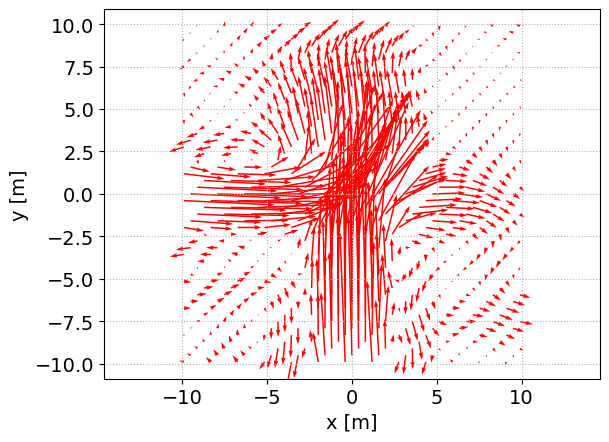

In [276]:
plot_wind_field(X_grid_torch, y_pred, 4, None, "/home/johanna/thesis_plots/AL_prediction")

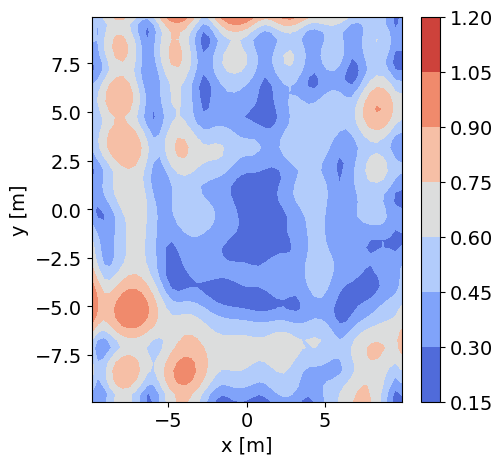

In [277]:
# Uncertainty map
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
name = '/home/johanna/thesis_plots/unc_active_learning'
unc = (unc_y0 + unc_y1).reshape(51,51)
fig = plt.figure()
w = 5
h = 5
fig.set_size_inches(w,h)
contourf_ = plt.contourf(x_grid, y_grid, unc, cmap='coolwarm')
cbar = fig.colorbar(contourf_)
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.xlim([-9.9,9.9])
plt.ylim([-9.9,9.9])
if not name==None:
    plt.savefig(name,  bbox_inches="tight")
plt.show()

## Full versus sparse GP comparison

In [317]:
# Full GP 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [343]:
class ExactGPyTorchRegression:
    def __init__(self, data):
        # Change dataset to torch tensor
        self.data = data
        data.read_data("torch")
        self.likelihood = []
        self.model = []
    def fit(self):
        for i in range(self.data.y.shape[1]):
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = ExactGPModel(self.data.X_train, self.data.y_train[:,i], likelihood)
            # Use the adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
            training_iter = 20
            for j in range(training_iter):
                # Zero gradients from previous iteration
                optimizer.zero_grad()
                # Output from model
                output = model(self.data.X_train)
                # Calc loss and backprop gradients
                loss = -mll(output, self.data.y_train[:,i])
                loss.backward()
                optimizer.step()
            self.likelihood.append(likelihood)
            self.model.append(model)        
    def get_kernel_params(self):
        self.sigma_f = []
        self.length_scale = []
        self.variance = []
        self.sigma_n = []
        for i in range(self.data.y.shape[1]):
            self.sigma_f.append(self.model[i].covar_module.outputscale.item())
            self.length_scale.append([self.model[i].covar_module.base_kernel.kernels[0].lengthscale.detach().numpy().item(0),
                                      self.model[i].covar_module.base_kernel.kernels[0].lengthscale.detach().numpy().item(1)])
            self.variance.append(self.model[i].covar_module.base_kernel.kernels[1].variance.item())
            self.sigma_n.append(self.likelihood[i].noise_covar.noise.item())
    def save_kernel_params(self):
        self.get_kernel_params()
        for i in range(self.data.y.shape[1]):
            name = "gpytorch_y" + str(i+1) + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
            self.data.save_kernel_params(name, self.length_scale[i], self.sigma_f[i], self.variance[i], self.sigma_n[i])
    def predict(self, X_test=None):
        if X_test == None:
            X_test = self.X_test
        self.mean = np.empty(X_test.shape)
        self.upper = np.empty(X_test.shape)
        self.lower = np.empty(X_test.shape)
        for i in range(self.data.y.shape[1]):
            self.model[i].eval()
            self.likelihood[i].eval()
            observed_pred = (self.model[i](X_test))
            self.mean[:,i] = observed_pred.mean.detach().numpy()
            lower, upper = observed_pred.confidence_region()
            self.upper[:,i] = upper.detach().numpy()
            self.lower[:,i] = lower.detach().numpy()
        #name = "gpytorch" + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
        #self.data.save_prediction(name, self.mean, self.upper, self.lower)
    def save_model(self):
        for i in range(self.data.y.shape[1]):
            print(self.model[i].state_dict())
            name = "gpytorch_y" + str(i+1) + "_model.pth"
            torch.save(self.model[i].state_dict(), name)

In [351]:
data = np.load('/home/johanna/MasterThesis/data/gauss_path/wind_data_4.npz')
X = data['X'][:,:]
y = data['y'][:,:]
data = Data()
data.set_data(X,y)

In [352]:
#Full GP model 
tic = time.time()
exact_gp_torch = ExactGPyTorchRegression(data)
exact_gp_torch.fit()
toc = time.time() -tic
tic = time.time()
exact_gp_torch.predict(X_grid_torch)
y_pred = exact_gp_torch.mean
toc2 = time.time() -tic
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc, toc, toc2)

0.024932657951813687 0.44092685887215877 1.0180437322705984 3.437520742416382 9.486392736434937


In [350]:
# Sparse GP model 
tic = time.time()
sparse_gp_torch = SparseGPyTorchRegression(data, 40, 20)
sparse_gp_torch.fit()
toc = time.time() -tic
tic = time.time()
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
toc2 = time.time() -tic
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc, toc, toc2)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/31 [00:00<?, ?it/s]

0.029145362139596242 0.44092685887215877 1.0180437322705984 16.179898500442505 0.06290674209594727


## Follow up windfields

<IPython.core.display.Javascript object>


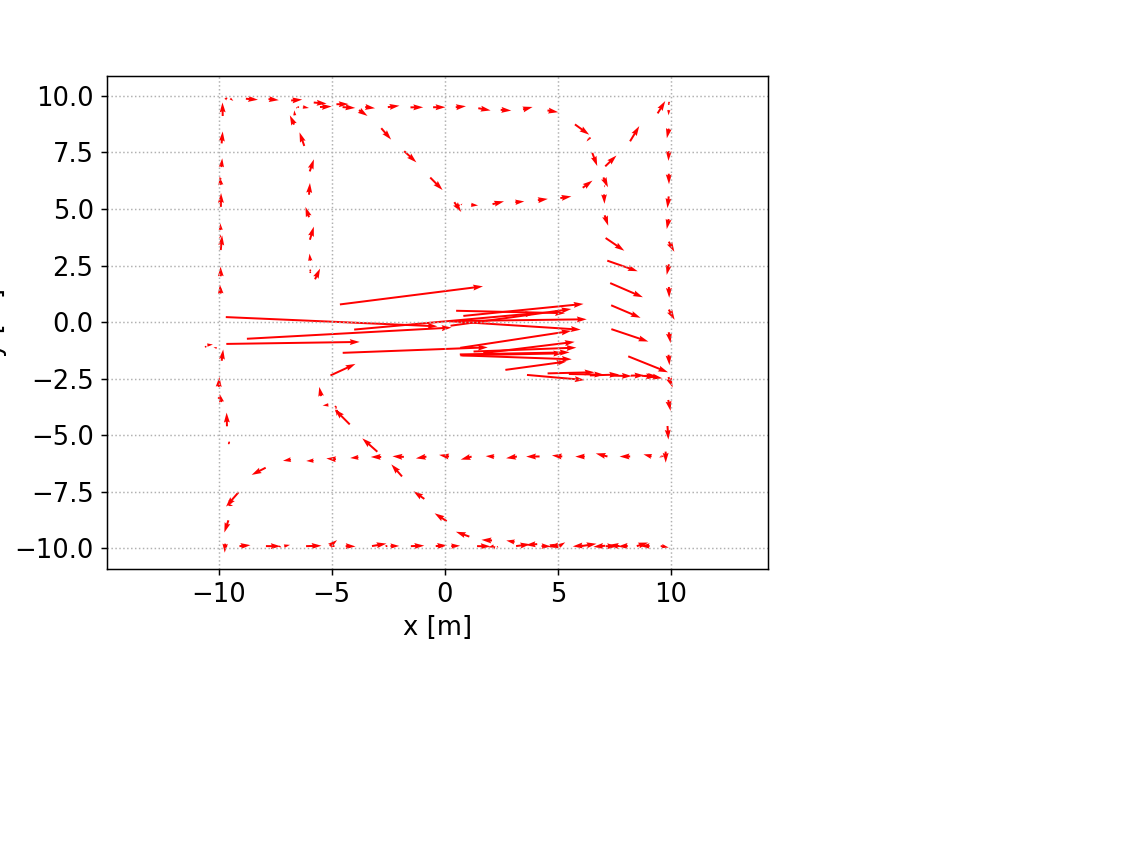

In [457]:
data_x_noise = np.load('/home/johanna/MasterThesis/data/SE_path_x_noise/wind_data_3.npz')
X = data_x_noise['X'][:,:]
y = data_x_noise['y'][:,:]
data_x_noise = Data()
data_x_noise.set_data(X,y)
plot_wind_field(X, y, 4, None, "/home/johanna/thesis_plots/final_x_data")

In [458]:
tic = time.time()
sparse_gp_torch = SparseGPyTorchRegression(data_x_noise, 30, 20)
sparse_gp_torch.fit()
toc = time.time() -tic
tic = time.time()
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
toc2 = time.time() -tic
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc, toc, toc2)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/32 [00:00<?, ?it/s]

1.3999750459616314 0.6890399771090981 0.8641775622963905 17.27880859375 0.11461853981018066


In [459]:
sparse_gp_torch.get_kernel_params()
len_scale = sparse_gp_torch.length_scale
sigma_f  = sparse_gp_torch.sigma_f
sigma_n = sparse_gp_torch.sigma_n
print(len_scale, sigma_f, sigma_n)

[[5.7724528312683105, 3.1219241619110107], [5.3339314460754395, 5.512638092041016]] [0.18016554415225983, 0.00934523530304432] [0.17476268112659454, 0.012552319094538689]


<IPython.core.display.Javascript object>


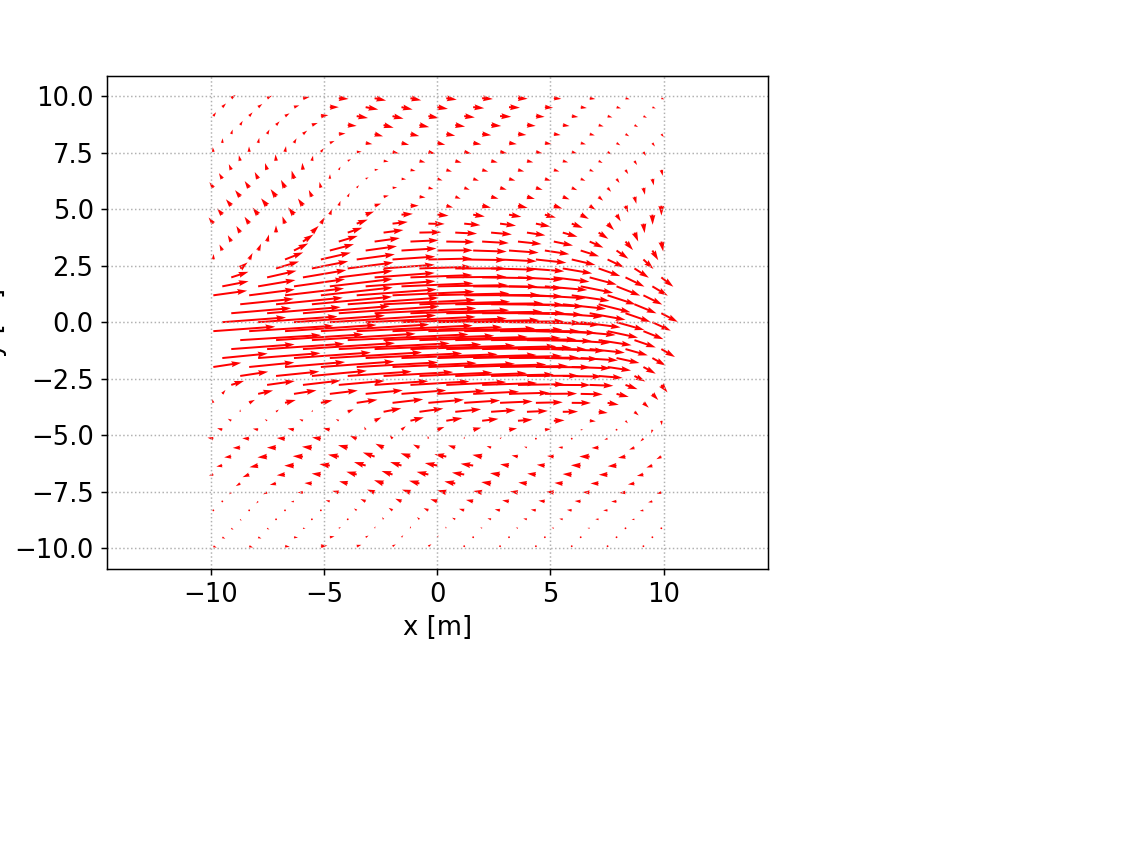

In [463]:
plot_wind_field(X_grid_torch, y_pred, 4, None, "/home/johanna/thesis_plots/final_x_results")

In [464]:
# Compare ground thruth against results with surface plot
def plot_surface(x, y, mean, true, upper, lower, bounds):
    mean_grid = mean.reshape(x.shape)
    true_grid = true.reshape(x.shape)
    fig = plt.figure()
    if bounds:
        upper_grid = upper.reshape(x.shape)
        lower_grid = lower.reshape(x.shape)
        ax = fig.gca(projection='3d')
        #ax.plot_surface(x, y, mean_grid,  color='C0', alpha=0.8)
        ax.plot_surface(x, y, true_grid,  color='C3', alpha=1)
        ax.plot_surface(x, y, upper_grid, cmap=cm.coolwarm, alpha=0.5)
        ax.plot_surface(x, y, lower_grid, cmap=cm.coolwarm, alpha=0.5)
    else:
        ax1 = fig.subplots(1, 1)
        ax1 = plt.contourf(x, y, mean_grid)
        plt.colorbar(ax1)
    plt.ioff()
    plt.show()

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


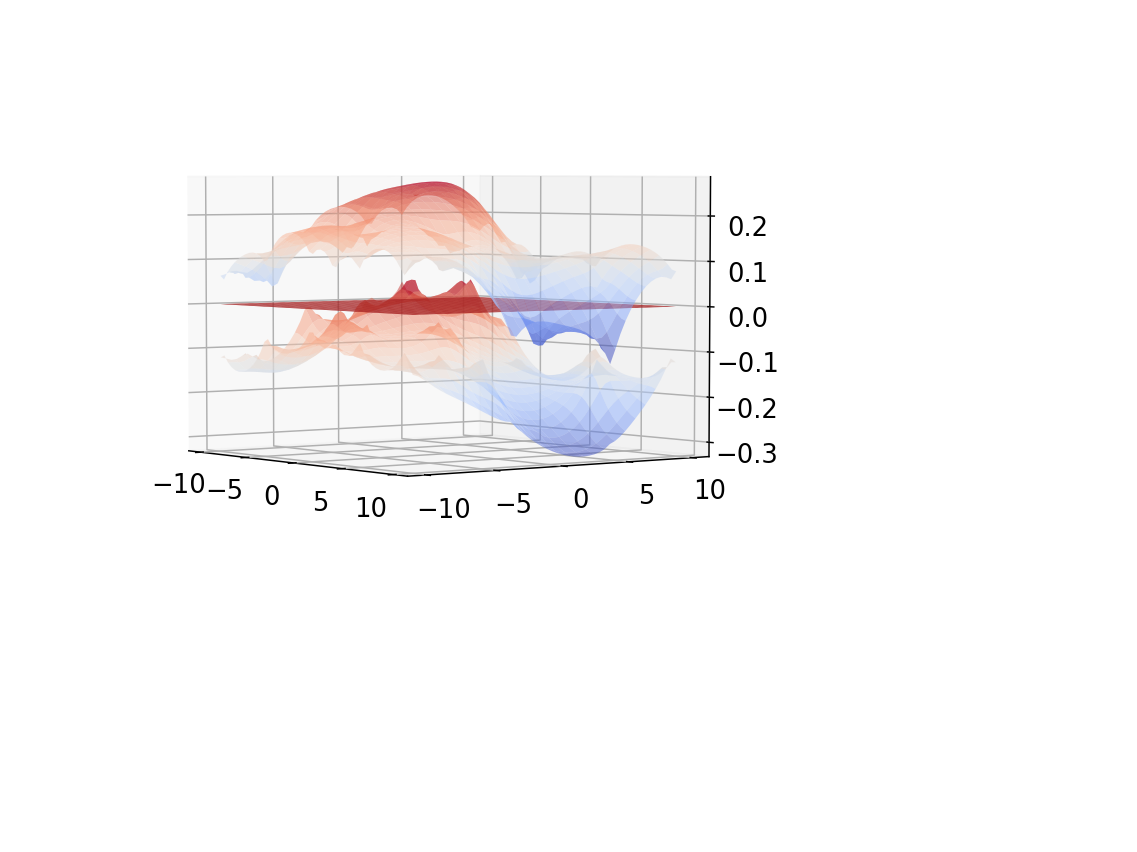

<IPython.core.display.Javascript object>


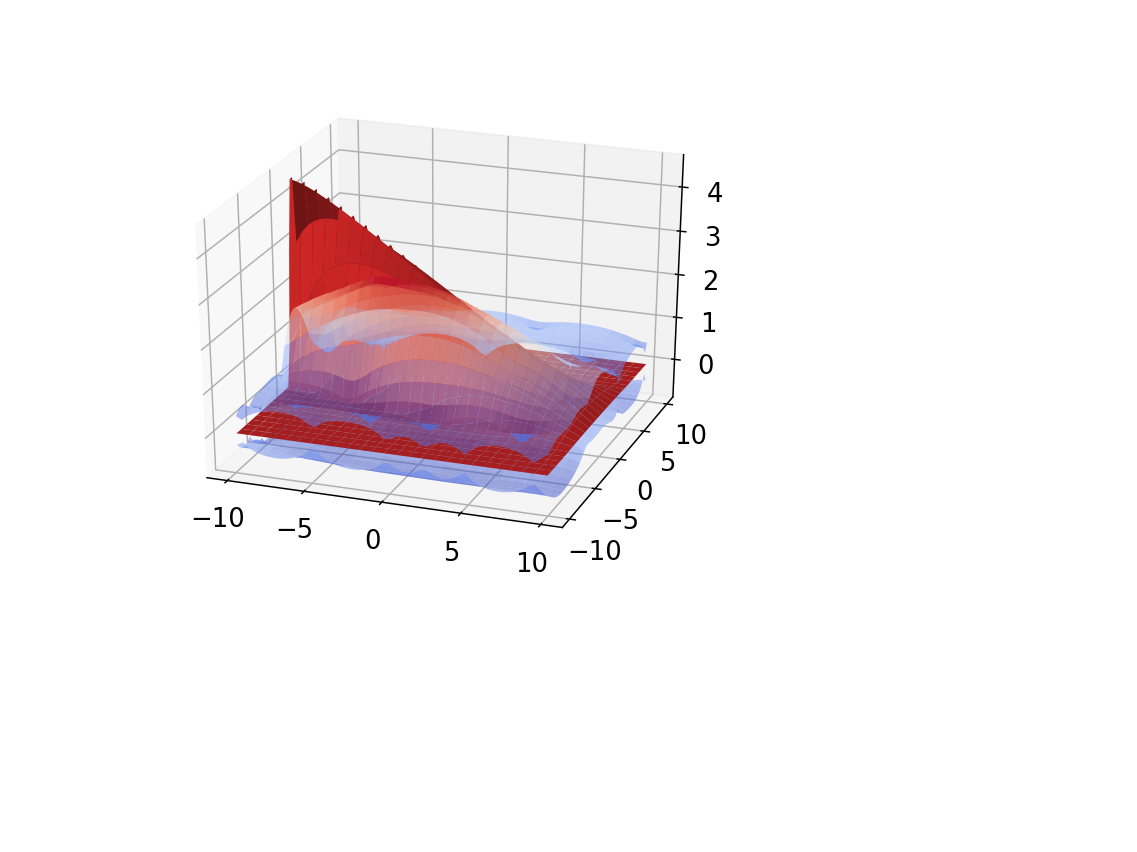

In [467]:
%matplotlib notebook
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,1], wind_gt[:,1], sparse_gp_torch.upper[:,1], sparse_gp_torch.lower[:,1], True)
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,0], wind_gt[:,0], sparse_gp_torch.upper[:,0], sparse_gp_torch.lower[:,0], True)

<IPython.core.display.Javascript object>


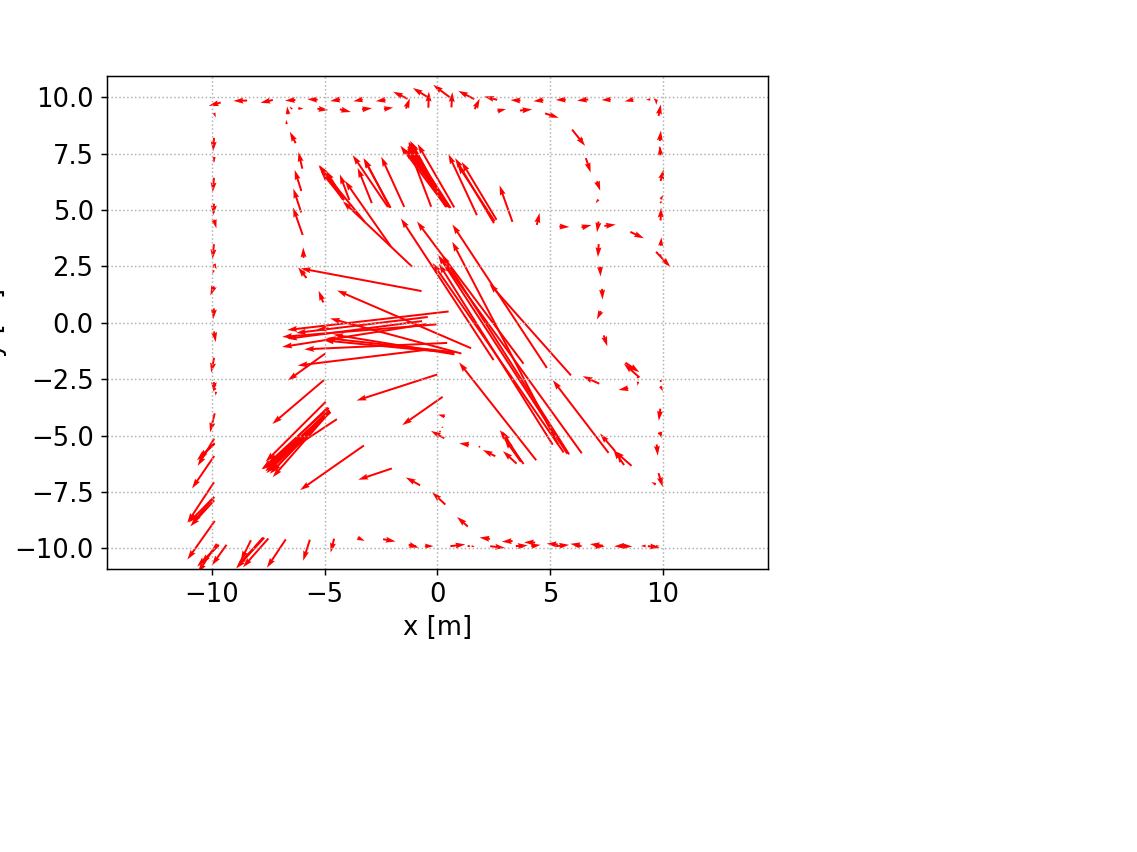

In [450]:
data_xy_noise = np.load('/home/johanna/MasterThesis/data/SE_path_xy_noise/wind_data_4.npz')
X = data_xy_noise['X'][:,:]
y = data_xy_noise['y'][:,:]
data_xy_noise = Data()
data_xy_noise.set_data(X,y)
plot_wind_field(X, y, 4, None, "/home/johanna/thesis_plots/final_xy_data")

In [451]:
tic = time.time()
sparse_gp_torch = SparseGPyTorchRegression(data_xy_noise, 40, 20)
sparse_gp_torch.fit()
toc = time.time() -tic
tic = time.time()
sparse_gp_torch.predict(X_grid_torch)
y_pred = sparse_gp_torch.mean
toc2 = time.time() -tic
MSE = mean_squared_error(wind_gt, y_pred)
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc = (unc_y0 + unc_y1)
mean_unc = np.mean(unc)
max_unc = np.max(unc)
print(MSE, mean_unc, max_unc, toc, toc2)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

0.09723132564516748 0.6967356878525074 1.4383696168661118 13.300772666931152 0.05391263961791992


<IPython.core.display.Javascript object>


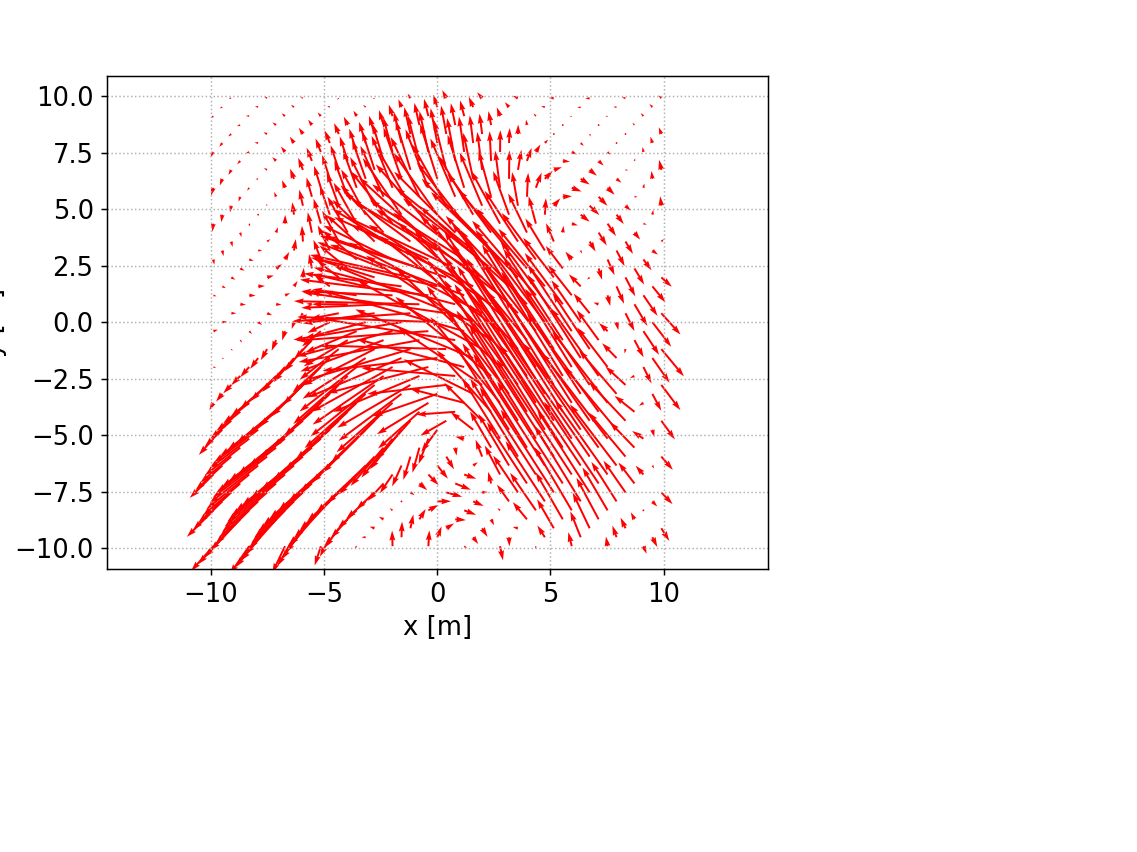

In [452]:
plot_wind_field(X_grid_torch, y_pred, 4, None, "/home/johanna/thesis_plots/final_xy_results")

In [453]:
sparse_gp_torch.get_kernel_params()
len_scale = sparse_gp_torch.length_scale
sigma_f  = sparse_gp_torch.sigma_f
sigma_n = sparse_gp_torch.sigma_n
print(len_scale, sigma_f, sigma_n)

[[3.3273684978485107, 3.3062217235565186], [2.537226438522339, 3.7208964824676514]] [0.37209752202033997, 0.43047666549682617] [0.0659281462430954, 0.11306033283472061]


Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent

<IPython.core.display.Javascript object>


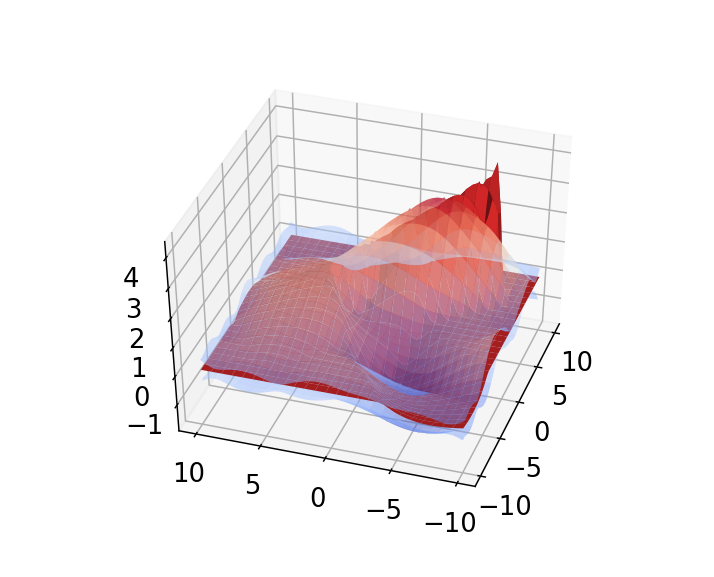

<IPython.core.display.Javascript object>


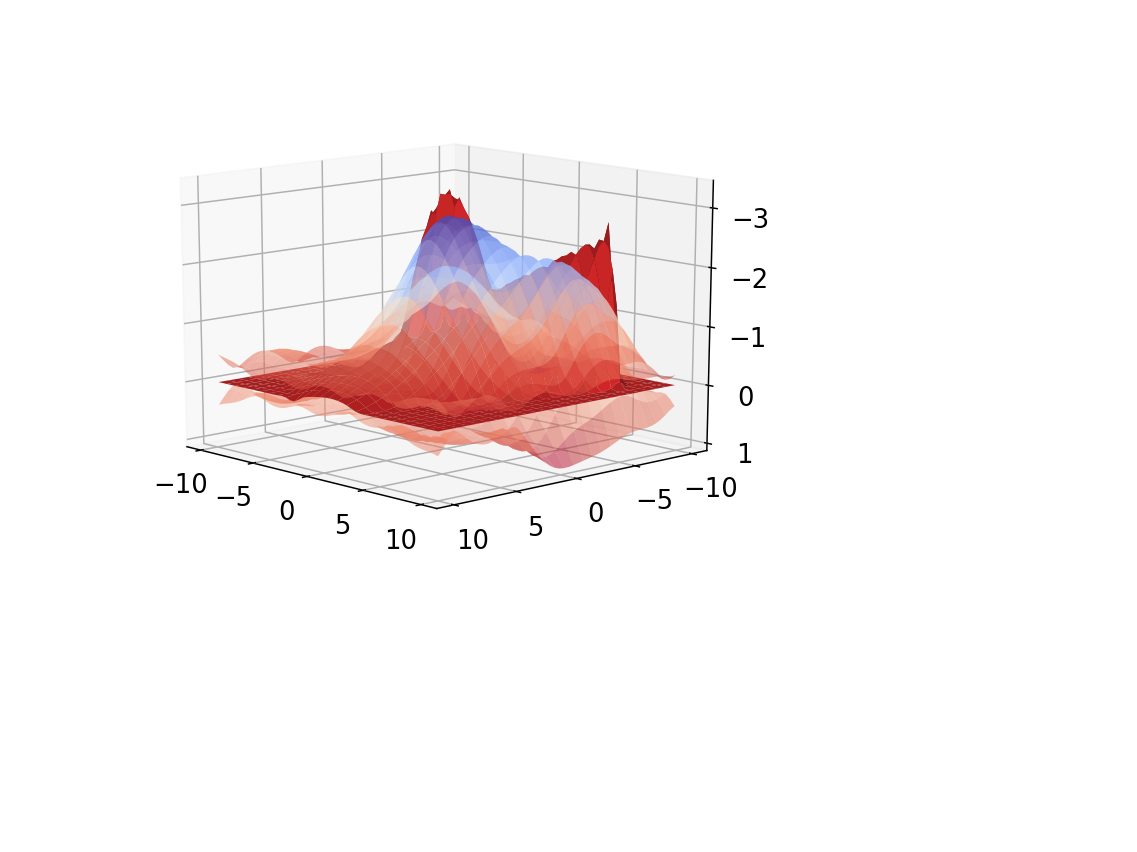

In [454]:
%matplotlib notebook
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,1], wind_gt[:,1], sparse_gp_torch.upper[:,1], sparse_gp_torch.lower[:,1], True)
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,0], wind_gt[:,0], sparse_gp_torch.upper[:,0], sparse_gp_torch.lower[:,0], True)